In [10]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import itertools
import matplotlib.colors as colors
import random
import regex as re

from string import punctuation
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import stopwords

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import text
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve
from sklearn.metrics import precision_score, recall_score, auc, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from scipy.optimize import linear_sum_assignment

from multiprocessing import Pool
from functools import lru_cache
# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from joblib import Memory

from umap import UMAP
import umap.plot

import hdbscan

from sklearnex import patch_sklearn 
patch_sklearn()

np.random.seed(0)
random.seed(0)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [11]:
def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data, columns=['text'])
    df['target'] = pd.Series(sklearn_dataset.target)
    return df

def plot_mat2(mat, xticklabels = None, yticklabels = None, pic_fname = None, size=(-1,-1), if_show_values = True,
             colorbar = True, grid = 'k', xlabel = None, ylabel = None, title = None, vmin=None, vmax=None):
    if size == (-1, -1):
        size = (mat.shape[1] / 3, mat.shape[0] / 3)

    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1,1,1)

    # im = ax.imshow(mat, cmap=plt.cm.Blues)
    im = ax.pcolor(mat, cmap=plt.cm.Blues, linestyle='-', linewidth=0.5, edgecolor=grid, vmin=vmin, vmax=vmax)
    
    if colorbar:
        plt.colorbar(im,fraction=0.046, pad=0.06)
    # tick_marks = np.arange(len(classes))
    # Ticks
    lda_num_topics = mat.shape[0]
    nmf_num_topics = mat.shape[1]
    yticks = np.arange(lda_num_topics)
    xticks = np.arange(nmf_num_topics)
    ax.set_xticks(xticks + 0.5)
    ax.set_yticks(yticks + 0.5)
    if xticklabels is None:
        xticklabels = [str(i) for i in xticks]
    if yticklabels is None:
        yticklabels = [str(i) for i in yticks]
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)

    # tick labels on all four sides
    ax.tick_params(labelright = True, labeltop = False)

    if ylabel:
        plt.ylabel(ylabel, fontsize=15)
    if xlabel:
        plt.xlabel(xlabel, fontsize=15)
    if title:
        plt.title(title, fontsize=15)

    # im = ax.imshow(mat, interpolation='nearest', cmap=plt.cm.Blues)
    ax.invert_yaxis()

    # thresh = mat.max() / 2

    def show_values(pc, fmt="%d", **kw):
        pc.update_scalarmappable()
        ax = pc.axes
        for p, color, value in itertools.zip_longest(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.all(color[:3] > 0.5):
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw, fontsize=10)

    if if_show_values:
        show_values(im)

    plt.tight_layout()
    if pic_fname:
        plt.savefig(pic_fname, dpi=300, transparent=True)
    plt.show()
    plt.close()

def get_cluster_metrics(true_labels, pred_labels):
    print('Homogeneity: ', metrics.homogeneity_score(true_labels, pred_labels) )
    print('Completeness: ', metrics.completeness_score(true_labels, pred_labels) )
    print('V measure: ', metrics.v_measure_score(true_labels, pred_labels) )
    print('Adjusted rand: ', metrics.adjusted_rand_score(true_labels, pred_labels) )
    print('Adjusted mutual info: ', metrics.adjusted_mutual_info_score(true_labels, pred_labels) )
    print('Avg. of All Metrics: ', get_avg_metric(true_labels, pred_labels) )

def get_avg_metric(true_labels, pred_labels):
    return ( metrics.homogeneity_score(true_labels, pred_labels) +
             metrics.completeness_score(true_labels, pred_labels) +
             metrics.v_measure_score(true_labels, pred_labels) +
             metrics.adjusted_rand_score(true_labels, pred_labels) +
             metrics.adjusted_mutual_info_score(true_labels, pred_labels) ) / 5

def custom_analyzer(text_data):
    tokenizer = CountVectorizer().build_analyzer()
    word_list = []
    stopwords = text.ENGLISH_STOP_WORDS
    for word in tokenizer(text_data):
        if (word not in stopwords) and not(any(ch.isdigit() for ch in word)):
            word_list.append(word)
    return word_list

In [12]:
from sklearn.datasets import fetch_20newsgroups
# comp_categories = [ 'comp.graphics', 
#                     'comp.os.ms-windows.misc', 
#                     'comp.sys.ibm.pc.hardware', 
#                     'comp.sys.mac.hardware']
# rec_categories = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
twenty_train = fetch_20newsgroups(  subset='all', 
                                    categories=None, 
                                    shuffle=True, 
                                    random_state=0,
                                    remove=('headers','footers') )
print(len(twenty_train.data))

18846


In [13]:
tr_df = sklearn_to_df(twenty_train)

In [14]:
#tr_df["text"] = tr_df["text"].apply(preprocess_stopwords)
vectorizer = CountVectorizer( min_df = 3,
                              analyzer = custom_analyzer,
                              stop_words = 'english' )

X_train_counts = vectorizer.fit_transform(tr_df['text'])
print(X_train_counts.shape)
print(vectorizer.get_feature_names_out()[:25])

c:\Users\eraye\anaconda3\envs\ece219\lib\site-packages\sklearn\feature_extraction\text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


(18846, 38627)
['__' '___' '____' '_____' '______' '_______' '________' '_________'
 '__________' '___________' '_____________' '_______________'
 '________________' '___________________' '____________________'
 '_____________________' '__________________________'
 '___________________________' '____________________________'
 '_______________________________' '________________________________'
 '__________________________________'
 '______________________________________________'
 '_______________________________________________'
 '_________________________________________________']


In [15]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print('Tf-idf train matrix: ')
print(X_train_tfidf.shape)

Tf-idf train matrix: 
(18846, 38627)


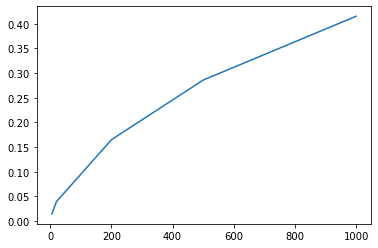

In [16]:
# explained var ratio
k_list = [5, 20, 200, 500, 1000]
var_rat_sum_list = []
svd_xtrainred_list = []
svd = TruncatedSVD(n_components=1000, tol=0.01, random_state=0)
X_train_reduced_svd = svd.fit_transform(X_train_tfidf) # U_k @ E_k   
for k in k_list:
    svd_xtrainred_list.append(X_train_reduced_svd[:,:k])    
    var_rat_sum_list.append(svd.explained_variance_ratio_[:k].sum())

plt.plot(k_list, var_rat_sum_list)

c:\Users\eraye\anaconda3\envs\ece219\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 50 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\eraye\anaconda3\envs\ece219\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 50 reached. Increase it to improve convergence.
  warnings.warn(


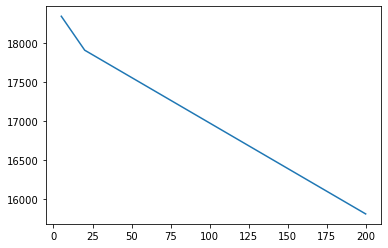

In [17]:
# explained var ratio
k_list = [5, 20, 200]
mse_list = []
nmf_model_list = []
nmf_xtrainred_list = []
for k in k_list:
    nmf_model = NMF(n_components=k, init='random', tol=0.01, max_iter=50, random_state=0)
    X_train_reduced_nmf = nmf_model.fit_transform(X_train_tfidf)    
    H = nmf_model.components_
    nmf_model_list.append(nmf_model)
    nmf_xtrainred_list.append(X_train_reduced_nmf)
    mse = np.sum(np.array(X_train_tfidf - X_train_reduced_nmf @ H)**2)
    mse_list.append(mse)

plt.plot(k_list, mse_list)

-------------QUESTION 10-------------

** Cluster metrics SVD n_component: 5 **
Homogeneity:  0.31118608814463394
Completeness:  0.3393268453448131
V measure:  0.3246477915170447
Adjusted rand:  0.12172056630494925
Adjusted mutual info:  0.3223649614309502
Avg. of All Metrics:  0.28384925054847826

** Cluster metrics NMF n_component: 5 **
Homogeneity:  0.23272146970354013
Completeness:  0.2629884392216891
V measure:  0.2469309367787652
Adjusted rand:  0.07369709155348869
Adjusted mutual info:  0.24431934044730486
Avg. of All Metrics:  0.2121314555409576
--------------------
** Cluster metrics SVD n_component: 20 **
Homogeneity:  0.31653967579038783
Completeness:  0.36658606453084447
V measure:  0.3397296490725167
Adjusted rand:  0.10700592430651026
Adjusted mutual info:  0.3374296946775616
Avg. of All Metrics:  0.2934582016755642

** Cluster metrics NMF n_component: 20 **
Homogeneity:  0.34972954867537415
Completeness:  0.4211375711183383
V measure:  0.38212617686138617
Adjusted rand:  0.10454075470728665
Adjusted mutual in

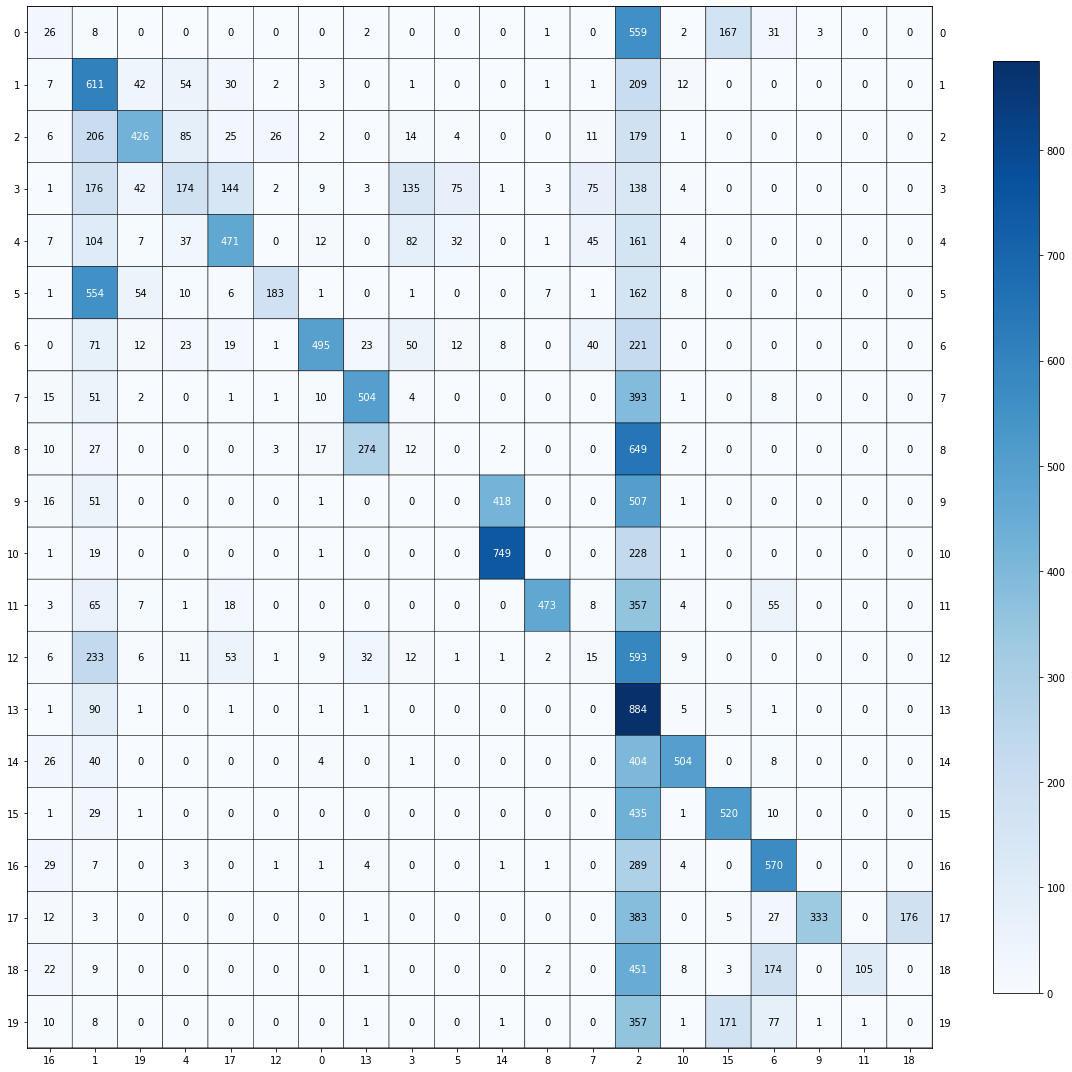

In [19]:
k_list = [5, 20, 200]
best_svdscore = 0.0
best_nmfscore = 0.0
for i in range(len(k_list)):
    kmeans_svd = KMeans( n_clusters=20, 
                    random_state=0, 
                    max_iter=1000, 
                    n_init=30)
    kmeans_svd.fit(svd_xtrainred_list[i]) 
    kmeans_svd_lab_tr_ = kmeans_svd.predict(svd_xtrainred_list[i])
    kmeans_svd_avgscore = get_avg_metric(tr_df['target'], kmeans_svd_lab_tr_)

    kmeans_nmf = KMeans( n_clusters=20, 
                    random_state=0, 
                    max_iter=1000, 
                    n_init=30)
    kmeans_nmf.fit(nmf_xtrainred_list[i])    
    kmeans_nmf_lab_tr_ = kmeans_nmf.predict(nmf_xtrainred_list[i])   
    kmeans_nmf_avgscore = get_avg_metric(tr_df['target'], kmeans_nmf_lab_tr_)

    if kmeans_svd_avgscore > best_svdscore:
        kmeans_svd_lab_tr = kmeans_svd_lab_tr_
        best_svdscore = kmeans_svd_avgscore
    if kmeans_nmf_avgscore > best_nmfscore:
        kmeans_nmf_lab_tr = kmeans_nmf_lab_tr_  
        best_nmfscore = kmeans_nmf_avgscore      

    print(f'** Cluster metrics SVD n_component: {k_list[i]} **')
    get_cluster_metrics(tr_df['target'], kmeans_svd_lab_tr_)
    print(f'\n** Cluster metrics NMF n_component: {k_list[i]} **')
    get_cluster_metrics(tr_df['target'], kmeans_nmf_lab_tr_)   
    print('-'*20)

print('\nBest metrics: ')
get_cluster_metrics(tr_df['target'], kmeans_svd_lab_tr)
cm = confusion_matrix(tr_df['target'], kmeans_svd_lab_tr)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat2( cm[rows[:, np.newaxis], cols], 
          xticklabels=cols, 
          yticklabels=rows, 
          size=(15,15) )

-------------QUESTION 11 & 12-------------

In [20]:
from umap import UMAP
import umap.plot

umap_param_list = [ [5, 'cosine'], 
                    [20, 'cosine'], 
                    [200, 'cosine'], 
                    [5, 'euclidean'],
                    [20, 'euclidean'],
                    [200, 'euclidean'] ]                  
umap_red_list = []
umap_xtrainred_list = []
cm_new_list = []
for i in range(len(umap_param_list)):
    umap_red = UMAP(  n_components=umap_param_list[i][0], 
                        metric=umap_param_list[i][1], 
                        random_state=0,
                        transform_seed=0 )    
    X_train_reduced_umap = umap_red.fit_transform( X_train_tfidf )
    umap_xtrainred_list.append(X_train_reduced_umap)
    umap_red_list.append(umap_red)

    kmeans_umap = KMeans( n_clusters=20, 
                        random_state=0, 
                        max_iter=1000, 
                        n_init=30)    
    kmeans_umap.fit(X_train_reduced_umap)
    kmeans_umap_lab_tr = kmeans_umap.predict(X_train_reduced_umap)             
    cm = confusion_matrix(tr_df['target'], kmeans_umap_lab_tr)
    rows, cols = linear_sum_assignment(cm, maximize=True)
    cm_new = cm[rows[:, np.newaxis], cols]
    cm_new_list.append(cm_new)
    print(f'*** n component: {umap_param_list[i][0]}, dist: {umap_param_list[i][1]} ***')           
    print('Cluster metrics: ')
    get_cluster_metrics(tr_df['target'], kmeans_umap_lab_tr)
    print('-'*40) 

*** n component: 5, dist: cosine ***
Cluster metrics: 
Homogeneity:  0.5634526378861818
Completeness:  0.5837348559448763
V measure:  0.5734144526102859
Adjusted rand:  0.4393089785993231
Adjusted mutual info:  0.572008979562294
Avg. of All Metrics:  0.5463839809205921
----------------------------------------
*** n component: 20, dist: cosine ***
Cluster metrics: 
Homogeneity:  0.5750415241290896
Completeness:  0.5966353124332333
V measure:  0.5856394335104578
Adjusted rand:  0.4559597481832506
Adjusted mutual info:  0.5842732013512166
Avg. of All Metrics:  0.5595098439214496
----------------------------------------
*** n component: 200, dist: cosine ***
Cluster metrics: 
Homogeneity:  0.5618968329283313
Completeness:  0.6015576690270731
V measure:  0.5810512546592352
Adjusted rand:  0.4326418176832598
Adjusted mutual info:  0.5796369081461005
Avg. of All Metrics:  0.5513568964888
----------------------------------------
*** n component: 5, dist: euclidean ***
Cluster metrics: 
Homogen


*** Permuted Conf. Mat. for n component: 5, dist: cosine : ***



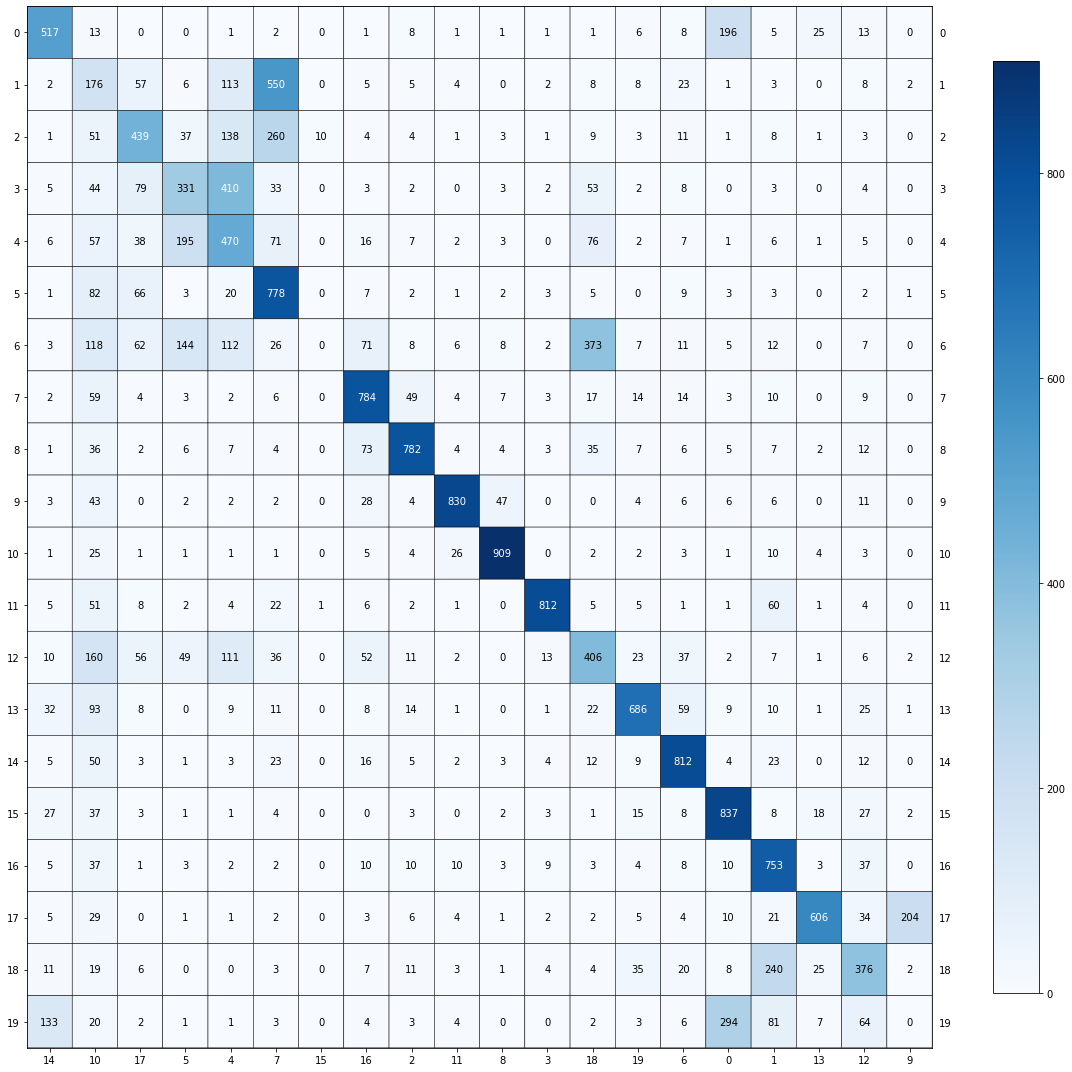

----------------------------------------

*** Permuted Conf. Mat. for n component: 20, dist: cosine : ***



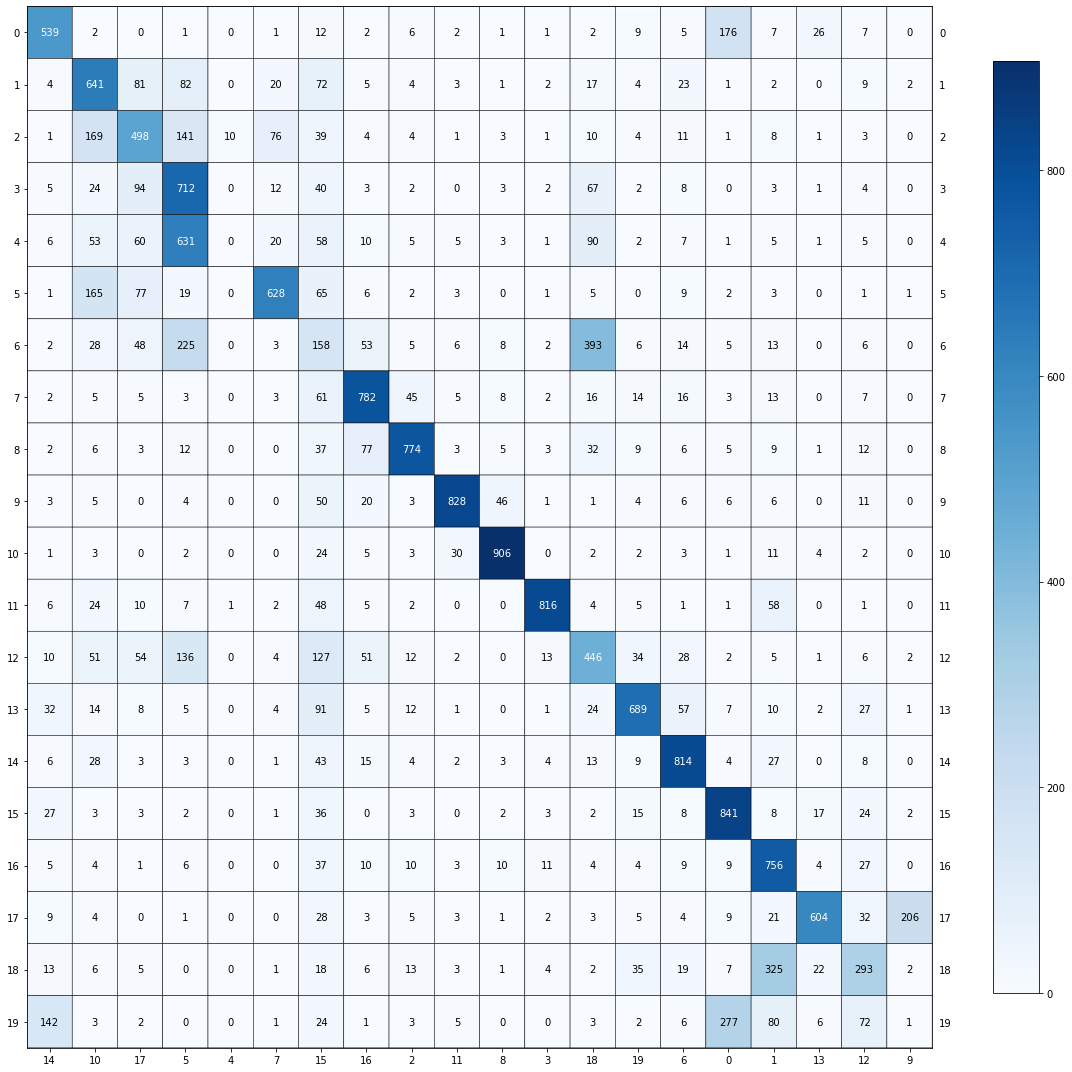

----------------------------------------

*** Permuted Conf. Mat. for n component: 200, dist: cosine : ***



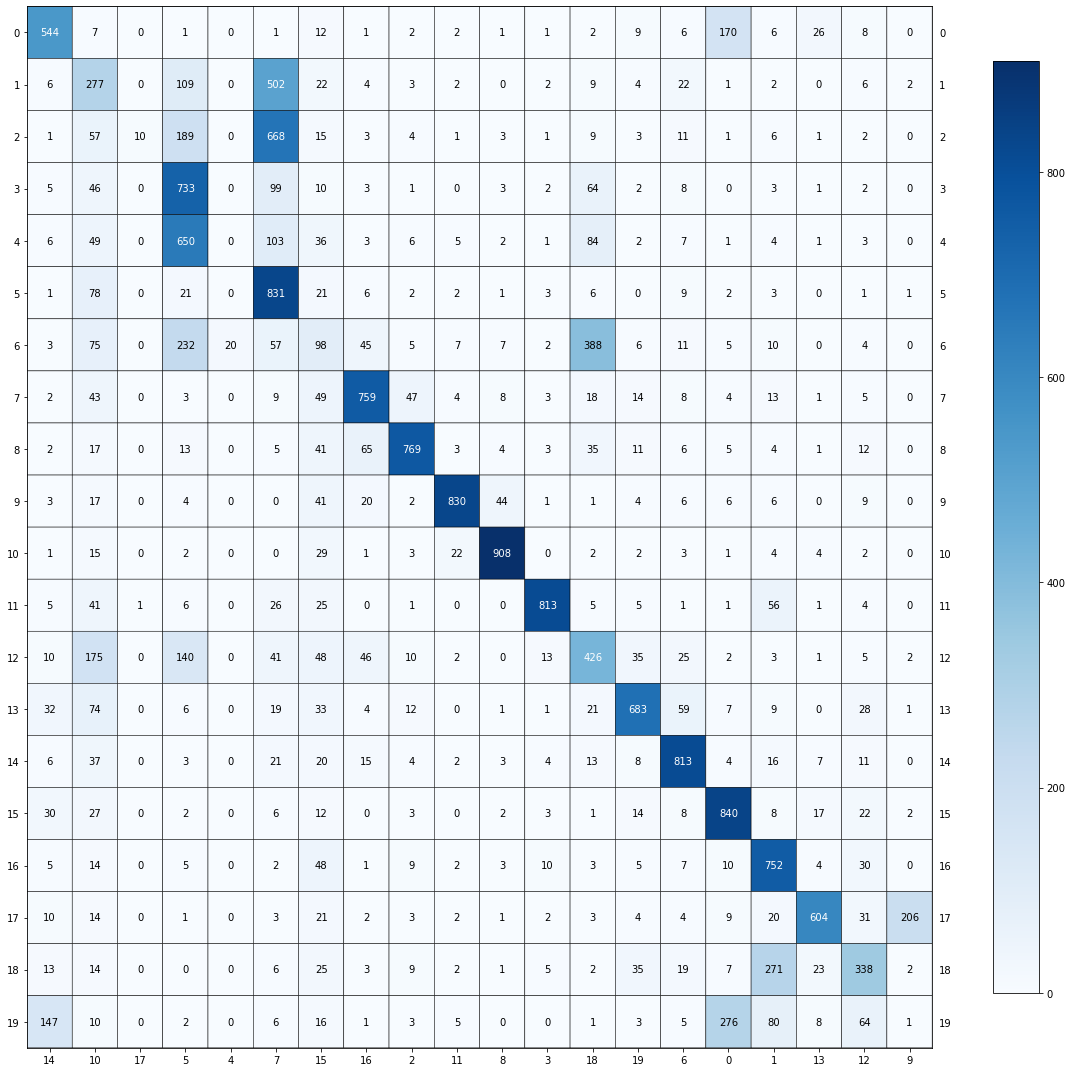

----------------------------------------

*** Permuted Conf. Mat. for n component: 5, dist: euclidean : ***



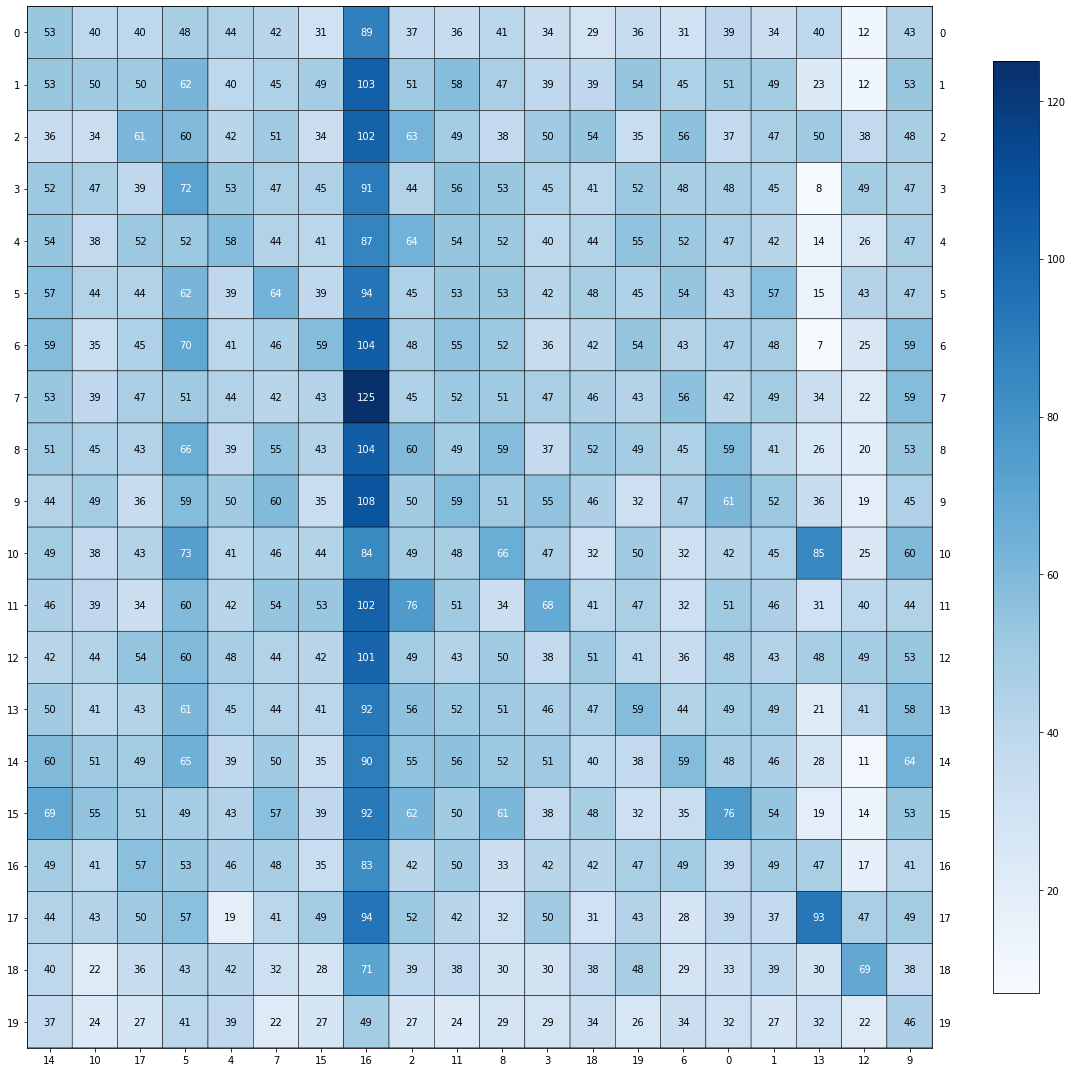

----------------------------------------

*** Permuted Conf. Mat. for n component: 20, dist: euclidean : ***



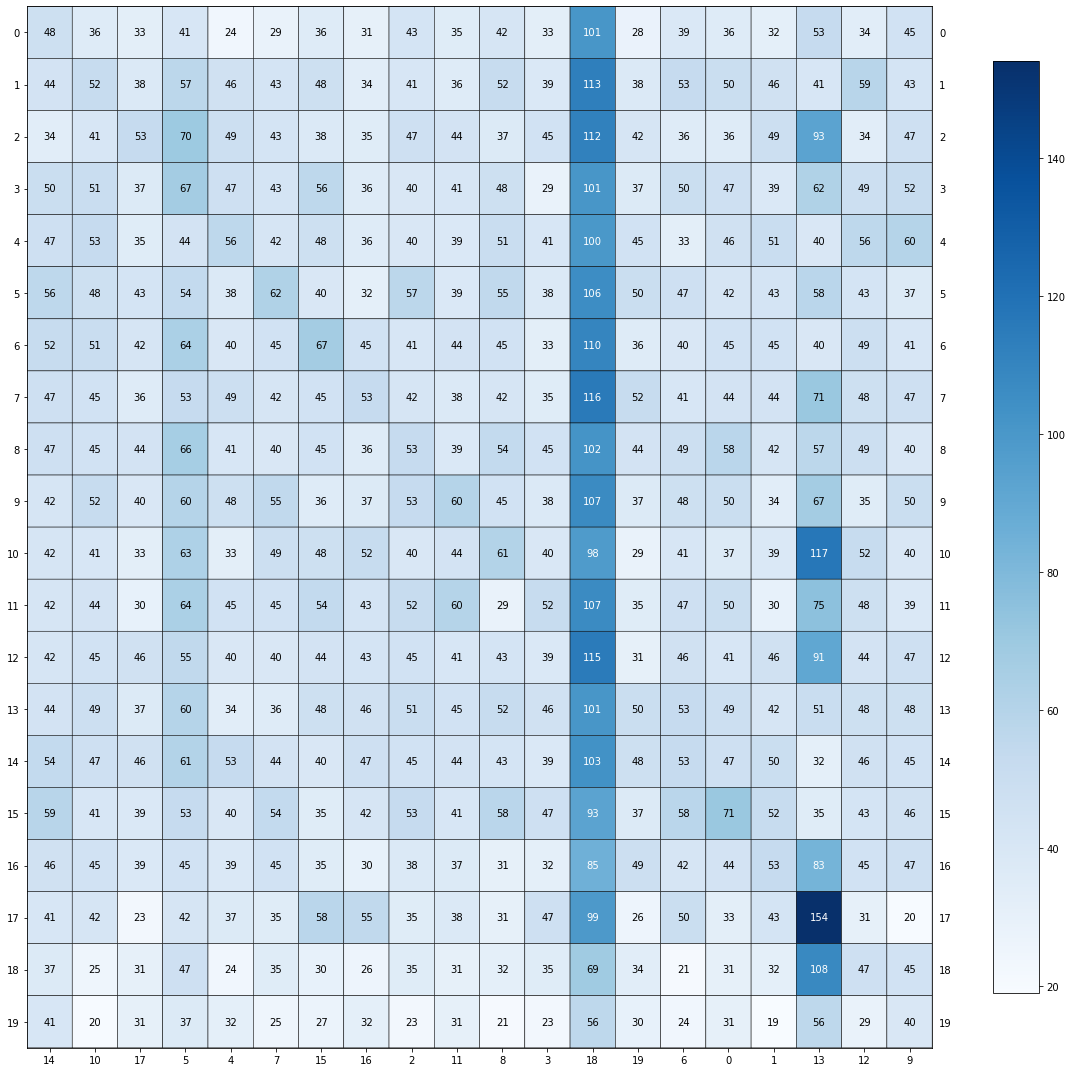

----------------------------------------

*** Permuted Conf. Mat. for n component: 200, dist: euclidean : ***



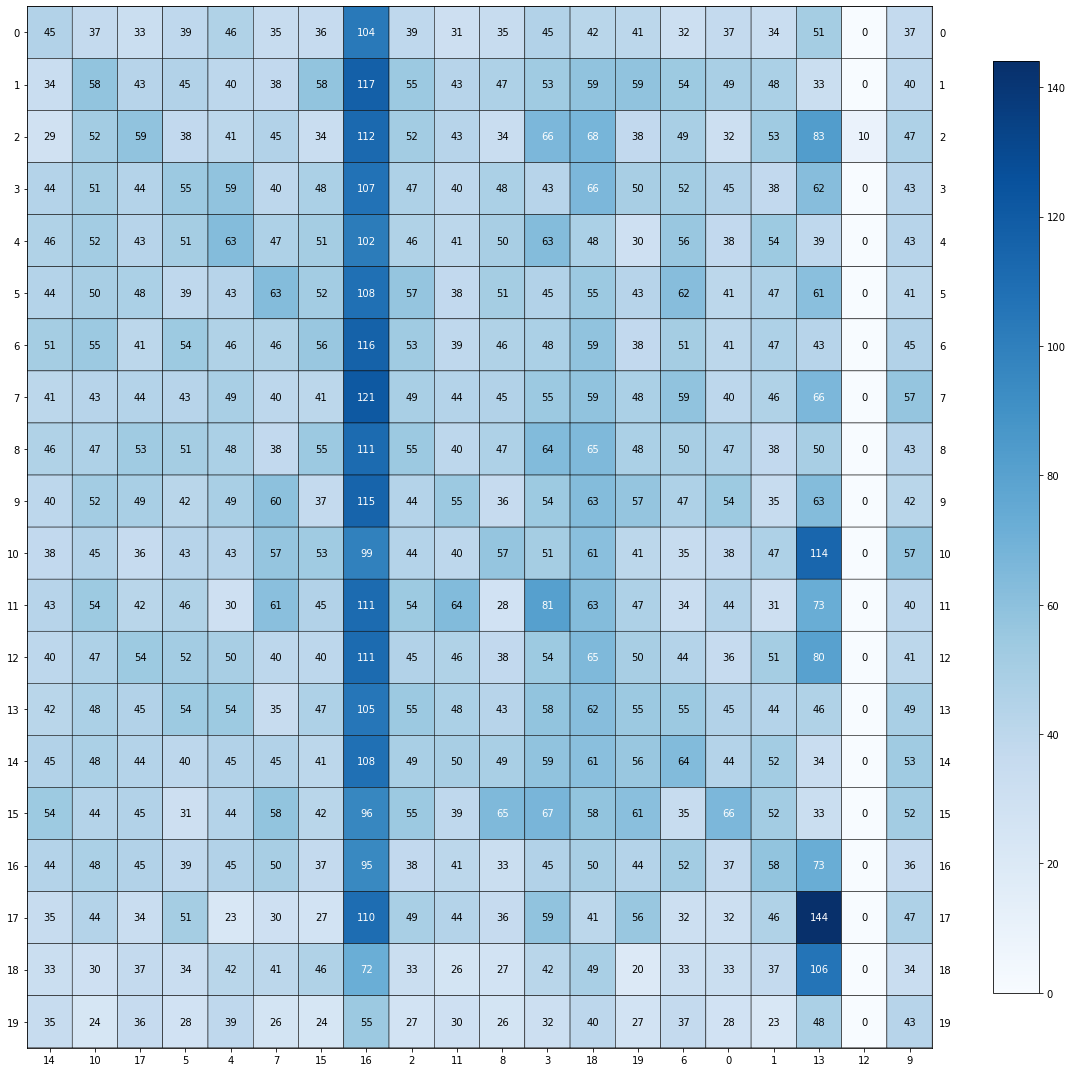

----------------------------------------


In [21]:
for i in range(len(umap_param_list)):
    print(f'\n*** Permuted Conf. Mat. for n component: {umap_param_list[i][0]}, dist: {umap_param_list[i][1]} : ***\n')
    plot_mat2( cm_new_list[i], 
                xticklabels=cols, 
                yticklabels=rows, 
                size=(15,15) )
    print('-'*40) 

-------------QUESTION 13-------------

In [22]:
kmeans_tfidf = KMeans( n_clusters=20, 
                    random_state=0, 
                    max_iter=1000, 
                    n_init=30)    
kmeans_tfidf.fit(X_train_tfidf)
kmeans_tfidf_lab_tr = kmeans_tfidf.predict(X_train_tfidf)   

# using n_components 5 and cosine dist umap  
X_train_reduced_umap = umap_red_list[0].fit_transform( X_train_tfidf )

kmeans_umap = KMeans( n_clusters=20, 
                    random_state=0, 
                    max_iter=1000, 
                    n_init=30)    
kmeans_umap.fit(X_train_reduced_umap)
kmeans_umap_lab_tr = kmeans_umap.predict(X_train_reduced_umap)   

print('Cluster metrics tfidf: ')
get_cluster_metrics(tr_df['target'], kmeans_tfidf_lab_tr)
print('-'*40) 
print('Cluster metrics pca: ')
get_cluster_metrics(tr_df['target'], kmeans_svd_lab_tr)
print('-'*40) 
print('Cluster metrics nmf: ')
get_cluster_metrics(tr_df['target'], kmeans_nmf_lab_tr)
print('-'*40) 
print('Cluster metrics umap: ')
get_cluster_metrics(tr_df['target'], kmeans_umap_lab_tr)

Cluster metrics tfidf: 
Homogeneity:  0.3583838430287652
Completeness:  0.41346328224711776
V measure:  0.3839583129626746
Adjusted rand:  0.1312572585477294
Adjusted mutual info:  0.38181811767713425
Avg. of All Metrics:  0.3337761628926842
----------------------------------------
Cluster metrics pca: 
Homogeneity:  0.36747797533945337
Completeness:  0.48733126979300667
V measure:  0.4190022729934056
Adjusted rand:  0.103082251369402
Adjusted mutual info:  0.4168451506442532
Avg. of All Metrics:  0.3587477840279042
----------------------------------------
Cluster metrics nmf: 
Homogeneity:  0.34972954867537415
Completeness:  0.4211375711183383
V measure:  0.38212617686138617
Adjusted rand:  0.10454075470728665
Adjusted mutual info:  0.3799333791062883
Avg. of All Metrics:  0.32749348609373474
----------------------------------------
Cluster metrics umap: 
Homogeneity:  0.5634526378861818
Completeness:  0.5837348559448763
V measure:  0.5734144526102859
Adjusted rand:  0.439308978599323

-------------QUESTION 14-------------

In [26]:
print(f'*** Agglomerative linkage: ward ***')   
aggtive_umap = AgglomerativeClustering( n_clusters=20, linkage='ward' )    
aggtive_umap.fit(X_train_reduced_umap)
aggtive_umap_lab_tr = aggtive_umap.labels_           
print('Cluster metrics: ')
get_cluster_metrics(tr_df['target'], aggtive_umap_lab_tr)
print('-'*40) 
print(f'*** Agglomerative linkage: single ***')   
aggtive_umap = AgglomerativeClustering( n_clusters=20, linkage='single' )    
aggtive_umap.fit(X_train_reduced_umap)
aggtive_umap_lab_tr = aggtive_umap.labels_          
print('Cluster metrics: ')
get_cluster_metrics(tr_df['target'], aggtive_umap_lab_tr)

*** Agglomerative linkage: ward ***
Cluster metrics: 
Homogeneity:  0.5536276161841515
Completeness:  0.5817746910155098
V measure:  0.5673522650091795
Adjusted rand:  0.42192635148469787
Adjusted mutual info:  0.565916472808527
Avg. of All Metrics:  0.5381194793004132
----------------------------------------
*** Agglomerative linkage: single ***
Cluster metrics: 
Homogeneity:  0.017314814507601122
Completeness:  0.3855215006174563
V measure:  0.03314116935962445
Adjusted rand:  0.0004661138875011502
Adjusted mutual info:  0.02806084851418227
Avg. of All Metrics:  0.09290088937727307


-------------QUESTION 15 & 16-------------

In [34]:
hdbscan_list = []           
hdbscan_minclus_list = [ 20, 100, 200 ]       
hdbscan_minsamp_list = [5, 20, 30, 40, 50, 60, 70, 80, 160, 500]
hdbscan_eps_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 2.0, 5]

hdbscan_model_list = [None] * len(hdbscan_minclus_list)
hdbscan_lab_list = [None] * len(hdbscan_minclus_list)
param_list = [None] * len(hdbscan_minclus_list)
ctr = 0
for minclus in hdbscan_minclus_list:
    best_avgscore = 0.0
    for minsamp in hdbscan_minsamp_list:
        for eps in hdbscan_eps_list:
            hdbscan_umap = hdbscan.HDBSCAN( min_cluster_size=minclus,
                                            min_samples=minsamp,
                                            cluster_selection_epsilon=eps) 
            hdbscan_umap.fit(X_train_reduced_umap)
            hdbscan_umap_lab_tr = hdbscan_umap.labels_
            print(f'*** HDBSCAN min cluster: {minclus}, min sample: {minsamp}, eps: {eps} ***')  
            get_cluster_metrics(tr_df['target'], hdbscan_umap_lab_tr)
            print('-'*40) 
            avgscore = get_avg_metric(tr_df['target'], hdbscan_umap_lab_tr)

            if avgscore > best_avgscore:
                hdbscan_model_list[ctr] = hdbscan_umap
                hdbscan_lab_list[ctr] = hdbscan_umap_lab_tr
                param_list[ctr] = (minclus, minsamp, eps)
                best_avgscore = avgscore
    ctr += 1

*** HDBSCAN min cluster: 20, min sample: 5, eps: 0.05 ***
Homogeneity:  0.4300547337185917
Completeness:  0.3655790487532783
V measure:  0.39520443683585216
Adjusted rand:  0.02082314021938647
Adjusted mutual info:  0.3722962314186463
Avg. of All Metrics:  0.31679151818915097
----------------------------------------
*** HDBSCAN min cluster: 20, min sample: 5, eps: 0.1 ***
Homogeneity:  0.430115638360457
Completeness:  0.3658095835745457
V measure:  0.3953648363473711
Adjusted rand:  0.02087587142150119
Adjusted mutual info:  0.3725810478555763
Avg. of All Metrics:  0.3169493955118902
----------------------------------------
*** HDBSCAN min cluster: 20, min sample: 5, eps: 0.2 ***
Homogeneity:  0.5181747299251256
Completeness:  0.4773337831254436
V measure:  0.4969165022953468
Adjusted rand:  0.19715238482598701
Adjusted mutual info:  0.48903592042285976
Avg. of All Metrics:  0.43572266411895255
----------------------------------------
*** HDBSCAN min cluster: 20, min sample: 5, eps: 0.

*** Best Cluster metrics for min cluster: 20 ***
For this min cluster - best min sample: 40, best eps: 0.5
For this min cluster - Est. no of clusters: 17, est no of noise points: 3069
For this min cluster - Best Cluster metrics: 
Homogeneity:  0.41377790744383053
Completeness:  0.5922018570466502
V measure:  0.48716694677695405
Adjusted rand:  0.22245904664292998
Adjusted mutual info:  0.48531396484514644
Avg. of All Metrics:  0.44018394455110216
For this min cluster - Permuted Conf. Mat.: 


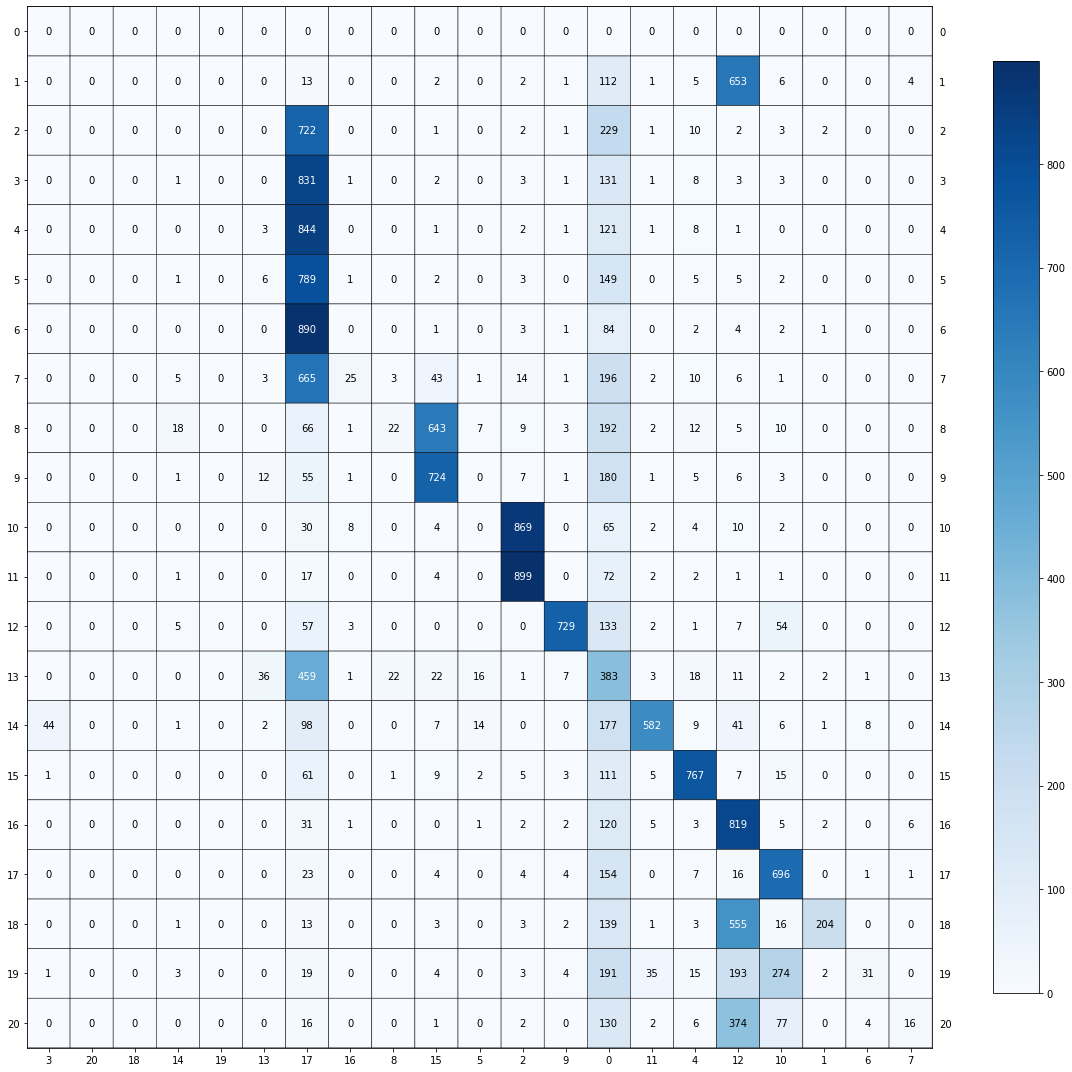

----------------------------------------
*** Best Cluster metrics for min cluster: 100 ***
For this min cluster - best min sample: 20, best eps: 0.05
For this min cluster - Est. no of clusters: 12, est no of noise points: 3468
For this min cluster - Best Cluster metrics: 
Homogeneity:  0.41986727796602735
Completeness:  0.5973741916565565
V measure:  0.49313340690102336
Adjusted rand:  0.21015930153059614
Adjusted mutual info:  0.4919180851826413
Avg. of All Metrics:  0.4424904526473689
For this min cluster - Permuted Conf. Mat.: 


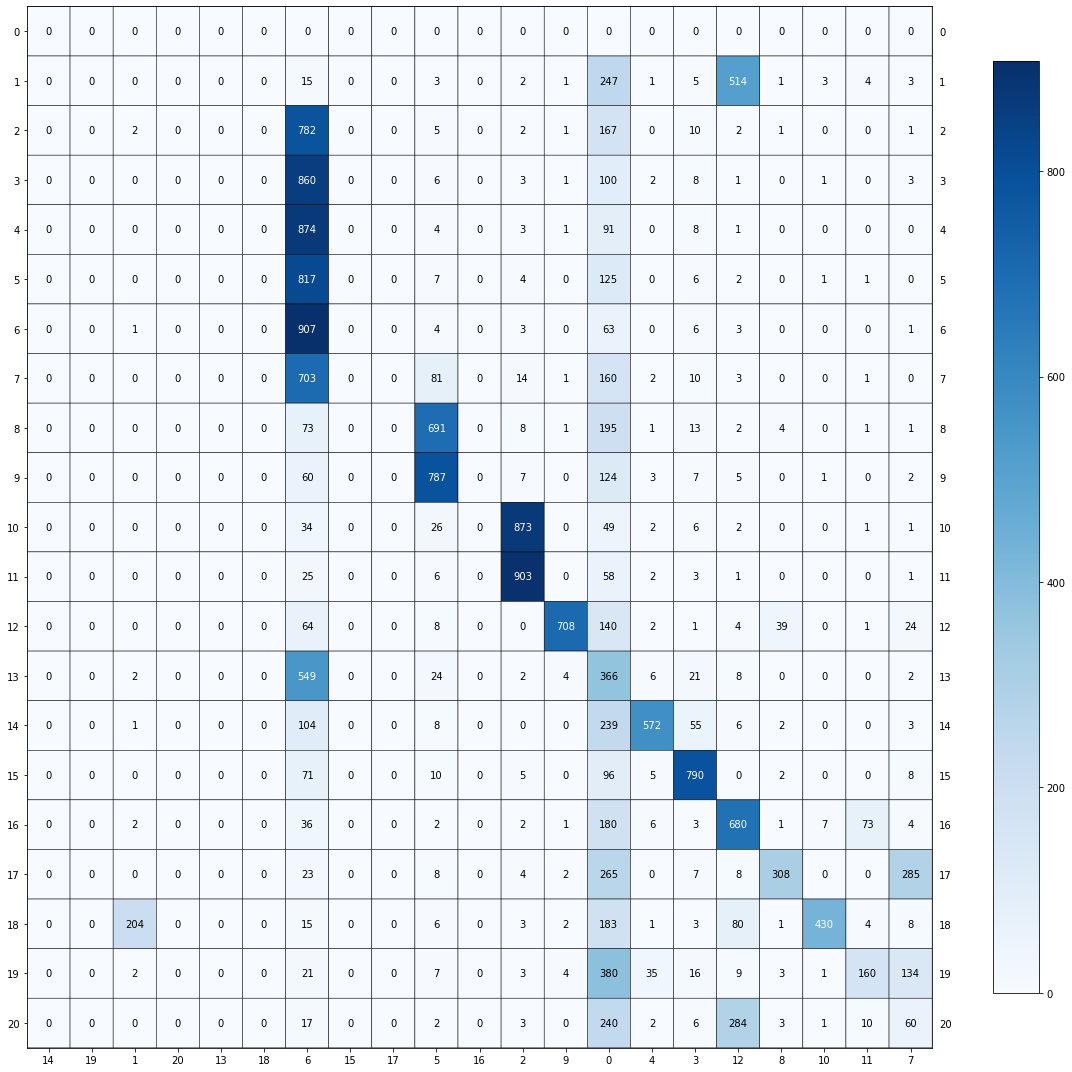

----------------------------------------
*** Best Cluster metrics for min cluster: 200 ***
For this min cluster - best min sample: 20, best eps: 0.05
For this min cluster - Est. no of clusters: 12, est no of noise points: 3468
For this min cluster - Best Cluster metrics: 
Homogeneity:  0.41986727796602735
Completeness:  0.5973741916565565
V measure:  0.49313340690102336
Adjusted rand:  0.21015930153059614
Adjusted mutual info:  0.4919180851826413
Avg. of All Metrics:  0.4424904526473689
For this min cluster - Permuted Conf. Mat.: 


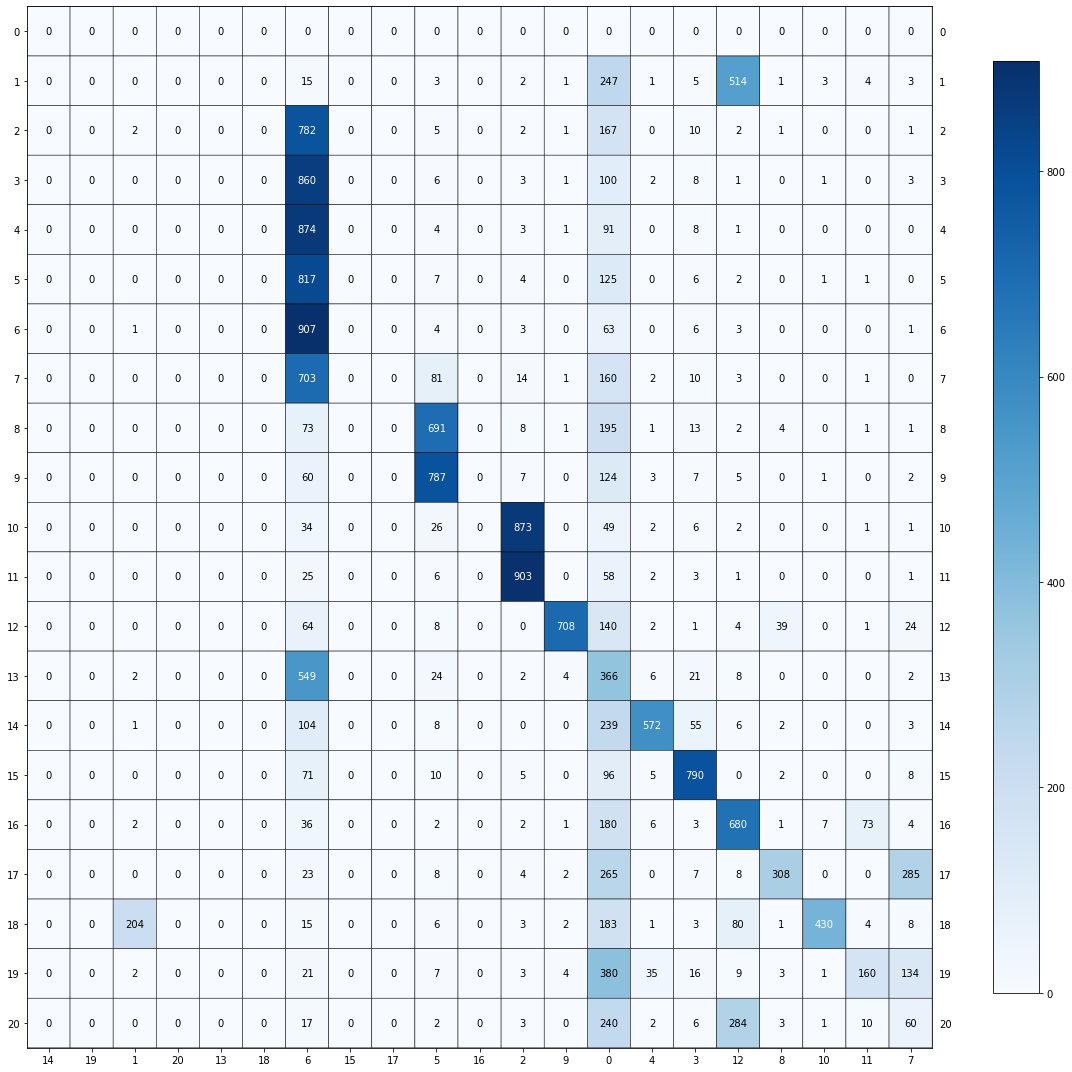

----------------------------------------


In [35]:
for i in range(len(hdbscan_lab_list)):
    cm = confusion_matrix(tr_df['target'], hdbscan_lab_list[i])
    rows, cols = linear_sum_assignment(cm, maximize=True)
    cm_new = cm[rows[:, np.newaxis], cols]
    print(f'*** Best Cluster metrics for min cluster: {param_list[i][0]} ***')   
    print(f'For this min cluster - best min sample: {param_list[i][1]}, best eps: {param_list[i][2]}') 
    n_clusters_ = len(set(hdbscan_lab_list[i])) - (1 if -1 in hdbscan_lab_list[i] else 0)
    n_noise_ = list(hdbscan_lab_list[i]).count(-1)
    print(f'For this min cluster - Est. no of clusters: {n_clusters_}, est no of noise points: {n_noise_}')                  
    print('For this min cluster - Best Cluster metrics: ')
    get_cluster_metrics(tr_df['target'], hdbscan_lab_list[i])
    print('For this min cluster - Permuted Conf. Mat.: ')
    plot_mat2( cm_new, 
                xticklabels=cols, 
                yticklabels=rows, 
                size=(15,15) )           
    print('-'*40) 

-------------QUESTION 17-------------

In [41]:
k_list = [5, 20, 200]
kmeans_n_clus_l = [10,20,50]
hdbscan_min_clus_l = [100, 200]
agg_n_clus = 20
svd_xtrainred_list = svd_xtrainred_list[:3]
umap_xtrainred_list = umap_xtrainred_list[:3]
input_list = [[X_train_tfidf.toarray(),0,0], 
             svd_xtrainred_list, nmf_xtrainred_list, umap_xtrainred_list]
input_list_keys = ['raw', 'svd', 'nmf', 'umap']
best_lab_param_list = []

is_first = False
best_score = 0.0
for i in range(len(k_list)):
    for j in range(len(input_list)):
        if is_first and j==0:
            continue

        for kmeans_n_clus in kmeans_n_clus_l:
            kmeans_lab_tr = KMeans( n_clusters=kmeans_n_clus, 
                                    random_state=0, 
                                    max_iter=1000, 
                                    n_init=30).fit_predict(input_list[j][i])     
            avg_score = get_avg_metric(tr_df['target'], kmeans_lab_tr)
            if avg_score > best_score:
                best_score = avg_score
                best_lab_param_list = [ kmeans_lab_tr, 
                                        (input_list_keys[j], k_list[i], 'kmeans', kmeans_n_clus) ]

        agg_lab_tr = AgglomerativeClustering( n_clusters=agg_n_clus, 
                                                linkage='ward' ).fit_predict(input_list[j][i])    
        avg_score = get_avg_metric(tr_df['target'], agg_lab_tr)
        if avg_score > best_score:
            best_score = avg_score
            best_lab_param_list = [ agg_lab_tr, 
                                    (input_list_keys[j], k_list[i], 'agglo. ward', agg_n_clus) ]

        for hdbscan_min_clus in hdbscan_min_clus_l:
            hdbscan_lab_tr = hdbscan.HDBSCAN( min_cluster_size=hdbscan_min_clus,
                                            min_samples=20,
                                            cluster_selection_epsilon=0.05).fit_predict(input_list[j][i])                 
            avg_score = get_avg_metric(tr_df['target'], hdbscan_lab_tr)
            if avg_score > best_score:
                best_score = avg_score
                best_lab_param_list = [ hdbscan_lab_tr, 
                                        (input_list_keys[j], k_list[i], 'hdbscan', hdbscan_min_clus) ]

        if is_first == False:
            is_first = True

In [ ]:
print('Best Model of Grid Search: ')
print(f'Dimension Red.: {best_lab_param_list[1][0]} - {best_lab_param_list[1][1]}')
print(f'Cluster approach: {best_lab_param_list[1][2]} - {best_lab_param_list[1][3]}')
print('Cluster metrics: ')
get_cluster_metrics(tr_df['target'], best_lab_param_list[0])
print('Permuted Conf. Mat.: ')
cm = confusion_matrix(tr_df['target'], best_lab_param_list[0])
rows, cols = linear_sum_assignment(cm, maximize=True)
cm_new = cm[rows[:, np.newaxis], cols]
print('Permuted Conf. Mat.: ')
plot_mat2( cm_new, 
            xticklabels=cols, 
            yticklabels=rows, 
            size=(15,15) )   